In [1]:
!pip install transformers
!pip3 install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 10.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from transformers import TFDistilBertModel, DistilBertTokenizer,TFBertModel,TFDistilBertForSequenceClassification
from tqdm import tqdm
from transformers import  AutoTokenizer
import tensorflow as tf

import pandas as pd
import numpy as np

In [4]:
# Load the training data into a pandas DataFrame

data=pd.read_csv('https://raw.githubusercontent.com/MMU-TDMLab/CompLex/master/train/lcp_single_train.tsv', sep='\t')
data.rename(columns = {'token':'word'}, inplace = True)

In [5]:
data.head()

,id,corpus,sentence,word,complexity
0,3ZLW647WALVGE8EBR50EGUBPU4P32A,bible,"Behold, there came up out of the river seven c...",river,0.000000
1,34R0BODSP1ZBN3DVY8J8XSIY551E5C,bible,I am a fellow bondservant with you and with yo...,brothers,0.000000
2,3S1WOPCJFGTJU2SGNAN2Y213N6WJE3,bible,"The man, the lord of the land, said to us, 'By...",brothers,0.050000
3,3BFNCI9LYKQN09BHXHH9CLSX5KP738,bible,Shimei had sixteen sons and six daughters; but...,brothers,0.150000
4,3G5RUKN2EC3YIWSKUXZ8ZVH95R49N2,bible,He has put my brothers far from me.\tbrothers\...,sons,0.055556


In [6]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import re
from contractions import contractions_dict

# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_text(text):
    # Remove special characters and non-alphanumeric characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Expanding the contractions i.e. can't becomes cant
    words = word_tokenize(text)
    words = [contractions_dict.get(word.lower(), word) for word in words]
    text = ' '.join(words)
    
    # Removing the commonly used english stop words
    words = word_tokenize(text)
    words = [word for word in words if word.lower() not in stop_words]
    text = ' '.join(words)
    
    # Lemmatizing the words in the sentences
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words)
    
    # Performing stemming on inputs
    words = word_tokenize(text)
    words = [stemmer.stem(word) for word in words]
    text = ' '.join(words)
    
    return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# Applying lemmatization, stemming, and punctuation removal to the dataframe
data['sentence'] = data['sentence'].apply(clean_text)

In [8]:
class MyDataset(tf.keras.utils.Sequence):
    def __init__(self, df, tokenizer_name, max_length, batch_size=32, shuffle=False):
        self.df = df
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def get_dataset(self):
        batch_inputs = self.tokenizer(list(self.df['sentence'].apply(str)),
                                      add_special_tokens=True, max_length=self.max_length, 
                                      padding='max_length',return_tensors='tf', truncation=True) ## tokenizing sentences
        batch_words = self.tokenizer(list(self.df['word'].apply(str)),
                                      add_special_tokens=True, max_length=self.max_length, 
                                      padding='max_length',return_tensors='tf', truncation=True) ## tokeninzing words
        batch_labels = tf.convert_to_tensor(self.df['complexity'].to_list(), dtype=tf.float32) ## complexity scores
        X = {'input_ids': batch_inputs['input_ids'],
             'words':batch_words['input_ids']}
        y = batch_labels
        return X, y

In [9]:
train_dataset = MyDataset(data, 'bert-base-cased',32)
#test_dataset = MyDataset(test_df, 'bert-base-cased', 128)
X_train, y_train = train_dataset.get_dataset()

In [10]:
X_train

{'input_ids': <tf.Tensor: shape=(7232, 32), dtype=int32, numpy=
 array([[  101,  1129,  8678, ...,     0,     0,     0],
        [  101,  3235, 10150, ...,     0,     0,     0],
        [  101,  1299,  7692, ...,     0,     0,     0],
        ...,
        [  101,  2255,  6812, ...,     0,     0,     0],
        [  101, 12647,  1813, ...,   182,  1197,   102],
        [  101,  1721, 13757, ...,  2027,  2493,   102]], dtype=int32)>,
 'words': <tf.Tensor: shape=(7232, 32), dtype=int32, numpy=
 array([[  101,  2186,   102, ...,     0,     0,     0],
        [  101,  3330,   102, ...,     0,     0,     0],
        [  101,  3330,   102, ...,     0,     0,     0],
        ...,
        [  101, 18653,  3161, ...,     0,     0,     0],
        [  101,   154, 11848, ...,     0,     0,     0],
        [  101,   185,  5024, ...,     0,     0,     0]], dtype=int32)>}

In [11]:
from transformers import TFRobertaModel , TFDistilBertModel
class LCP(tf.keras.Model):
    def __init__(self):
        super(LCP, self).__init__()

        # Bert
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')
        # roberta
        self.roberta = TFRobertaModel.from_pretrained('roberta-base')

        # Concatenation layer
        self.concat = tf.keras.layers.Concatenate()
        # linear layers
        self.linear1 = tf.keras.layers.Dense(1024, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.dropout1 = tf.keras.layers.Dropout(0.2)
        self.linear2 = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.linear3 = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.linear4 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.dropout2 = tf.keras.layers.Dropout(0.2)
        self.linear5 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))
        self.linear6 = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.001)) # linear activation

    def call(self, inputs):
        input_ids = inputs['input_ids']
        words = inputs['words']

        
        attention_mask = tf.concat(
              [tf.ones_like(input_ids), tf.zeros_like(words)], axis=1)  # attention mask 

        # RoBERTa output
        roberta_output=self.roberta(input_ids=(input_ids, words),attention_mask=(attention_mask,))[0]

        # BERT output
        bert_output = self.bert(input_ids=(input_ids, words),attention_mask=(attention_mask,))[0]


        # Concatenate RoBERTa and BERT outputs
        concat_output = self.concat([bert_output[:, 0], bert_output[:, -1],roberta_output[:, 0], roberta_output[:, -1]])

        # Linear layers
        x = self.linear1(concat_output)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        x = self.dropout2(x)
        x = self.linear5(x)
        x = self.linear6(x)
    
        return x

In [13]:
model = LCP()

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
              loss=tf.keras.losses.MeanAbsoluteError(),metrics=['mae','mse'])


early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

history = model.fit(x=X_train, y=y_train,
                    batch_size=32,
                    epochs=250,
                    validation_split=0.3,
                    callbacks=[early_stopping_callback])
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobe

Epoch 1/250


159/159 [==============================] - 181s 594ms/step - loss: 3.4325 - mae: 0.1404 - mse: 0.0327 - val_loss: 3.3400 - val_mae: 0.0880 - val_mse: 0.0115
Epoch 2/250
159/159 [==============================] - 76s 475ms/step - loss: 3.3350 - mae: 0.1238 - mse: 0.0257 - val_loss: 3.2554 - val_mae: 0.0865 - val_mse: 0.0135
Epoch 3/250
159/159 [==============================] - 76s 476ms/step - loss: 3.2457 - mae: 0.1186 - mse: 0.0240 - val_loss: 3.1724 - val_mae: 0.0881 - val_mse: 0.0142
Epoch 4/250
159/159 [==============================] - 76s 481ms/step - loss: 3.1590 - mae: 0.1171 - mse: 0.0235 - val_loss: 3.0930 - val_mae: 0.0951 - val_mse: 0.0163
Epoch 5/250
159/159 [==============================] - 76s 476ms/step - loss: 3.0685 - mae: 0.1134 - mse: 0.0220 - val_loss: 3.0043 - val_mae: 0.0929 - val_mse: 0.0150
Epoch 6/250
159/159 [==============================] - 74s 468ms/step - loss: 2.9759 - mae: 0.1067 - mse: 0.0198 - val_loss: 2.9291 - val_mae: 0.1030 - val_mse: 0.0175
Epo

In [14]:
model.save('/content/drive/MyDrive/nlp_final_project/model_final')

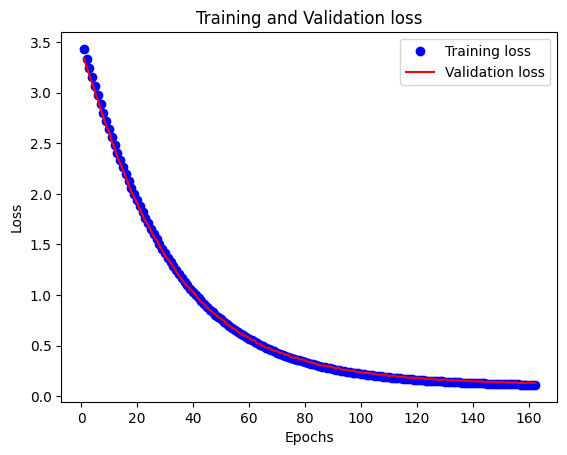

In [16]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [17]:
# Load the training data into a pandas DataFrame

test=pd.read_csv('https://raw.githubusercontent.com/MMU-TDMLab/CompLex/master/test-labels/lcp_single_test.tsv', sep='\t')
test.rename(columns = {'token':'word'}, inplace = True)

In [18]:
test_dataset = MyDataset(test, 'bert-base-cased',32)
#test_dataset = MyDataset(test_df, 'bert-base-cased', 128)
X_test, y_test = test_dataset.get_dataset()

In [19]:
X_test

{'input_ids': <tf.Tensor: shape=(887, 32), dtype=int32, numpy=
 array([[  101,  1252,  1119, ...,   119,   102,     0],
        [  101,  1409,   146, ...,     0,     0,     0],
        [  101,  1103,  1995, ...,  1113,  1103,   102],
        ...,
        [  101,   118,  1828, ...,   114,  1449,   102],
        [  101,   146,  1156, ...,     0,     0,     0],
        [  101, 24693,  1103, ...,     0,     0,     0]], dtype=int32)>,
 'words': <tf.Tensor: shape=(887, 32), dtype=int32, numpy=
 array([[  101,  1289,   102, ...,     0,     0,     0],
        [  101,  1289,   102, ...,     0,     0,     0],
        [  101,  1289,   102, ...,     0,     0,     0],
        ...,
        [  101,  2664,  7810, ...,     0,     0,     0],
        [  101, 17916,  1182, ...,     0,     0,     0],
        [  101, 23950,   102, ...,     0,     0,     0]], dtype=int32)>}

In [20]:
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test Loss, Test MAE,Test MSE:", results)


28/28 [==============================] - 4s 145ms/step - loss: 0.1316 - mae: 0.0948 - mse: 0.0158
Test Loss, Test MAE,Test MSE: [0.13164174556732178, 0.09476865082979202, 0.015835968777537346]


In [24]:
y_pred=model.predict(X_test)

28/28 [==============================] - 4s 132ms/step


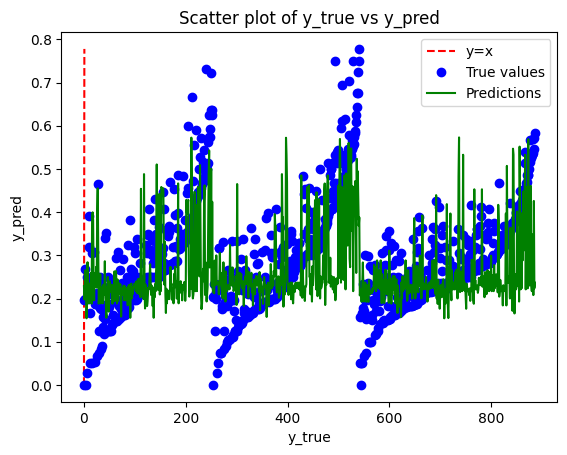

In [28]:
y_true = y_test.numpy()
y_pred = y_pred

min_value = np.min([np.min(y_true), np.min(y_pred)])
max_value = np.max([np.max(y_true), np.max(y_pred)])
x = np.linspace(min_value, max_value, num=100)
y = x

# plotting the curve of true values and predicted values for the test set
plt.plot(x, y, 'r--', label='y=x')
plt.plot(y_true, 'bo', label='True values')
plt.plot(y_pred, 'g', label='Predictions')

plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.title('Scatter plot of y_true vs y_pred')

# Adding a legend
plt.legend()

plt.show()

In [29]:
def predict_lcp_score(model, sentence, word, tokenizer_name, max_length):
    # Creating a DataFrame containing the sentence and the given word
    tokenizer=AutoTokenizer.from_pretrained('bert-base-cased')
    df = pd.DataFrame({'sentence': [sentence], 'word': [word]})
    
    #tokenizing sentences and words using BERT tokeninzer
    batch_inputs = tokenizer(list(df['sentence'].apply(str)),
                                      add_special_tokens=True, max_length=max_length, 
                                      padding='max_length',return_tensors='tf', truncation=True)
    batch_words = tokenizer(list(df['word'].apply(str)),
                                      add_special_tokens=True, max_length=max_length, 
                                      padding='max_length',return_tensors='tf', truncation=True)
    X = {'input_ids': batch_inputs['input_ids'],
             'words':batch_words['input_ids']}
     
    # Makeing the prediction using the model
    prediction = model(X)[0]
    
    return prediction


In [30]:
sentence = 'The children of Ammon gathered themselves together from their cities, and came to battle.'
word = 'battle'
sentence=clean_text(sentence)
lcp_score = predict_lcp_score(model, sentence, word, 'bert-base-uncased', 32)

# Print the LCP score
print('LCP score:', lcp_score)
print('True Value : ( test dataset number 15 ) :', 0.21)

LCP score: tf.Tensor([0.22875552], shape=(1,), dtype=float32)
True Value : ( test dataset number 15 ) : 0.21


In [34]:
## showing the performance on 10 random samples from test set 
n=500 # first index in the list of 10 consecutive indexes

for i in range (n,n+10):
  lcp_score=predict_lcp_score(model, test['sentence'][i:i+1], test['word'][i:i+1], 'bert-base-uncased', 32)
  print(f'LCP score for index {i} :',lcp_score)
  print('True value for that index :',test['complexity'][i:i+1])


LCP score for index 500 : tf.Tensor([0.3590299], shape=(1,), dtype=float32)
True value for that index : 500    0.431818
Name: complexity, dtype: float64
LCP score for index 501 : tf.Tensor([0.22593658], shape=(1,), dtype=float32)
True value for that index : 501    0.466667
Name: complexity, dtype: float64
LCP score for index 502 : tf.Tensor([0.5324187], shape=(1,), dtype=float32)
True value for that index : 502    0.45
Name: complexity, dtype: float64
LCP score for index 503 : tf.Tensor([0.5737404], shape=(1,), dtype=float32)
True value for that index : 503    0.513158
Name: complexity, dtype: float64
LCP score for index 504 : tf.Tensor([0.46987167], shape=(1,), dtype=float32)
True value for that index : 504    0.464286
Name: complexity, dtype: float64
LCP score for index 505 : tf.Tensor([0.47092816], shape=(1,), dtype=float32)
True value for that index : 505    0.466667
Name: complexity, dtype: float64
LCP score for index 506 : tf.Tensor([0.40041086], shape=(1,), dtype=float32)
True v